## Price Analysis

In [1]:
%matplotlib notebook
%matplotlib widget

#### Imports

In [2]:
import sqlite3
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

#### Set up

In [3]:
def repo_root(start=None) -> Path:
    p = Path(start or Path.cwd()).resolve()
    while p != p.parent and not (p / ".git").exists():
        p = p.parent
    return p

ROOT = repo_root()
DB = (ROOT / "events.db").resolve()
print("DB:", DB, "| exists:", DB.exists(), "| size(bytes):", DB.stat().st_size if DB.exists() else 0)

DB: /Users/student/Desktop/NWU_MLDS/400/final/ticketmaster-data-collection/events.db | exists: True | size(bytes): 4231168


#### One-time Index Creation : add indexes to speeds up reads/filters/joins

In [4]:
CREATE_INDEXES = True  # set False if already done / no write perms needed
if CREATE_INDEXES:
    with sqlite3.connect(f"file:{DB}?mode=rw", uri=True) as con_rw:  # read-write, only if file exists
        con_rw.executescript("""
        CREATE INDEX IF NOT EXISTS ix_events_event_id    ON events(event_id);
        CREATE INDEX IF NOT EXISTS ix_events_datetime    ON events(datetime);
        CREATE INDEX IF NOT EXISTS ix_prices_event_date  ON event_price_history(event_id, snapshot_date);
        CREATE INDEX IF NOT EXISTS ix_prices_currency    ON event_price_history(currency);
        """)
        con_rw.commit()

#### Open read-only for all analysis

In [5]:
con = sqlite3.connect(f"file:{DB}?mode=ro", uri=True)
q = lambda sql, params=None: pd.read_sql(sql, con, params=params)

#### Pull events (only those with a scheduled datetime)

In [24]:
events = q("""
    SELECT event_id, name, type, segment, genre, subgenre, family,
           datetime, onsale_date, offsale_date, venue_id
    FROM events
    WHERE datetime IS NOT NULL
""")
for c in ["datetime", "onsale_date", "offsale_date"]:
    if c in events.columns:
        events[c] = pd.to_datetime(events[c], errors="coerce", utc=True).dt.tz_localize(None)
print("Events with scheduled datetime:", len(events))

Events with scheduled datetime: 4410


In [25]:
events.shape

(4410, 11)

#### Pull price history filtered in SQL (USD, non-negative, pre-event)

In [26]:
pricedf = q("""
    SELECT e.event_id, e.name, e.type, e.segment, e.genre, e.subgenre, e.family,
           e.datetime, e.onsale_date, e.offsale_date, e.venue_id,
           p.snapshot_date, p.min_price, p.max_price, p.currency
    FROM events e
    JOIN (
        SELECT event_id, snapshot_date, min_price, max_price, currency
        FROM event_price_history
        WHERE currency='USD'
          AND min_price IS NOT NULL
          AND min_price >= 0
    ) p ON p.event_id = e.event_id
    WHERE e.datetime IS NOT NULL
""")
for c in ["datetime", "onsale_date", "offsale_date", "snapshot_date"]:
    pricedf[c] = pd.to_datetime(pricedf[c], errors="coerce", utc=True).dt.tz_localize(None)
print("Price records after filtering:", len(pricedf))

Price records after filtering: 1755


In [27]:
pricedf

,event_id,name,type,segment,genre,subgenre,family,datetime,onsale_date,offsale_date,venue_id,snapshot_date,min_price,max_price,currency
0,rZ7HnEZ1AfAbON,Ticket for you + 1 for ALL 2025 shows!,event,Music,World,World,None,2025-01-09 08:00:00,2025-01-09 13:35:00,2025-02-01 05:55:00,rZ7HnEZ178s4g,2025-11-03,199.00,199.00,USD
1,rZ7HnEZ1Af_6QK,MOBWEEN 3 NIGHT PASS - Acid Mothers Temple (10...,event,Music,Alternative,Alternative Rock,None,2025-10-30 20:00:00,2025-10-27 22:00:00,2025-10-31 01:00:00,rZ7HnEZ1734-A,2025-11-03,49.51,49.51,USD
2,rZ7HnEZ1AfbKPK,"Vinyl Weekend Pass (4 Rooms, 8+ Artists)",event,Music,Other,None,None,2025-10-31 22:00:00,2025-10-10 16:00:00,2025-11-02 07:00:00,rZ7HnEZ17qf40,2025-11-03,33.95,33.95,USD
3,rZ7HnEZ1AK87bK,Lil Ed & Blues Imperials/Joanna Connor Band,event,Music,Blues,Blues,None,2025-11-01 19:00:00,2024-01-06 00:15:00,2025-11-01 23:30:00,rZ7HnEZa7JQ,2025-11-03,23.00,23.00,USD
4,rZ7HnEZ1AKQkuV,Sabados Sabrosos!,event,Music,World,Latin,None,2025-11-01 19:00:00,2025-02-04 17:45:00,2025-11-02 01:00:00,rZ7HnEZ173pGP,2025-11-03,25.18,25.18,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750,rZ7HnEZ1Afp84S,Tank and the Bangas,event,Music,R&B,Funk,None,2026-02-01 20:00:00,2025-10-08 17:00:00,2026-02-02 03:00:00,rZ7HnEZaeUG,2025-11-05,31.55,31.55,USD
1751,rZ7HnEZ1Aff6rd,9 Years of Birmingham Bandstand Celebration at...,event,Music,Rock,Rock & Roll,None,2026-02-02 19:00:00,2025-08-21 15:00:00,2026-02-03 01:00:00,rZ7HnEZ17ogjP,2025-11-05,4.60,4.60,USD
1752,rZ7HnEZ1Af_dfd,Blue Monday: Ivan Singh,event,Music,Blues,Blues,None,2026-02-02 20:00:00,2025-10-29 15:00:00,2026-02-03 02:00:00,rZ7HnEZa5n1,2025-11-05,0.00,0.00,USD
1753,rZ7HnEZ1AKrk40,Ruston Kelly,event,Music,Rock,Folk Rock,None,2026-02-02 20:00:00,2025-06-10 17:00:00,2026-02-03 04:00:00,rZ7HnEZadXm,2025-11-05,38.13,165.03,USD


#### Feature engineering in Python

In [28]:
# Cheapest price (first time it occurs) per event:
cheapest = (
    pricedf.dropna(subset=["min_price"])
           .sort_values(["event_id", "min_price", "snapshot_date"])
           .groupby("event_id", as_index=False)
           .first()[["event_id", "min_price", "snapshot_date"]]
           .rename(columns={"min_price": "cheapest_price",
                            "snapshot_date": "cheapest_seen_at"})
)

feat = (
    events.merge(cheapest, on="event_id", how="left")
          .assign(
              days_before_event=lambda d: (d["datetime"] - d["cheapest_seen_at"]).dt.days,
              month=lambda d: d["datetime"].dt.month,
              weekday=lambda d: d["datetime"].dt.day_name(),
              hour=lambda d: d["datetime"].dt.hour
          )
)

print(
    f"Events total: {len(events):,} | with cheapest observed: {feat['cheapest_price'].notna().sum():,}"
)

Events total: 4,410 | with cheapest observed: 767


cheapest_price is the lowest observed min_price for each event before the event date

#### Visualizations

In [29]:
from matplotlib.ticker import StrMethodFormatter

def as_currency(ax):
    ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

##### sale window vs price: from onsale_date to offsale_date and its relation to cheapest price.

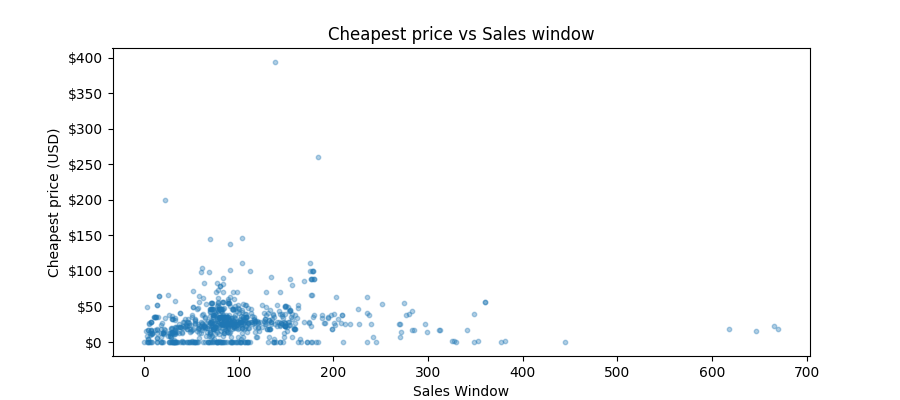

In [30]:
feat3 = feat.assign(
    sales_window_days=(feat["offsale_date"] - feat["onsale_date"]).dt.days
)
plt.figure(figsize=(9,4))
plt.scatter(feat3["sales_window_days"], feat3["cheapest_price"], s=10, alpha=0.35)
plt.title("Cheapest price vs Sales window")
plt.xlabel("Sales Window"); plt.ylabel("Cheapest price (USD)")
as_currency(plt.gca()); plt.show()

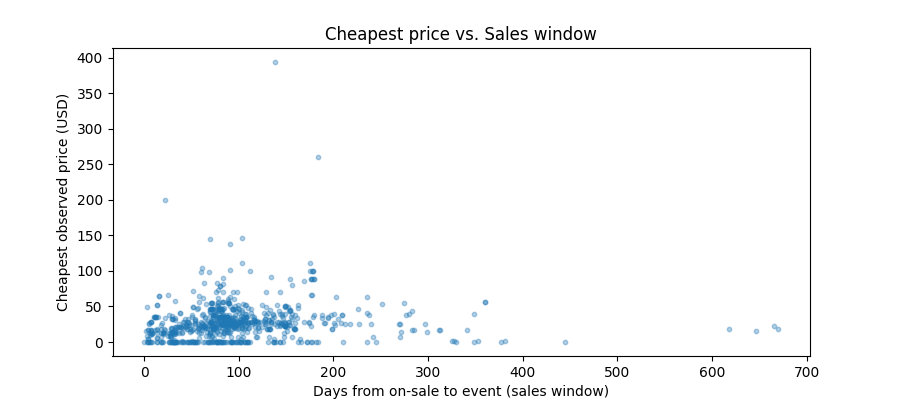

In [31]:
import mplcursors
# feat already exists; build feat3 with the lead-time column
feat3 = feat.assign(
    sales_window_days=(feat["offsale_date"] - feat["onsale_date"]).dt.days
).dropna(subset=["sales_window_days", "cheapest_price"])

fig, ax = plt.subplots(figsize=(9, 4))
pts = ax.scatter(
    feat3["sales_window_days"],
    feat3["cheapest_price"],
    s=10, alpha=0.35
)

ax.set_title("Cheapest price vs. Sales window")
ax.set_xlabel("Days from on-sale to event (sales window)")
ax.set_ylabel("Cheapest observed price (USD)")

cursor = mplcursors.cursor(pts, hover=True)

@cursor.connect("add")
def on_add(sel):
    i = sel.index
    row = feat3.iloc[i]
    name = str(row.get("name", ""))[:60]  # trim long names
    event_id = row.get("event_id", "")
    lead = int(row["sales_window_days"])
    price = float(row["cheapest_price"])
    when = row["offsale_date"].date() if hasattr(row["offsale_date"], "date") else row["offsale_date"]
    onsale = row["onsale_date"].date() if hasattr(row["onsale_date"], "date") else row["onsale_date"]

    sel.annotation.set(
        text=(
            f"{name}\n"
            f"Event ID: {event_id}\n"
            f"Cheapest: ${price:,.2f}\n"
            f"Sales Window: {lead} days\n"
            f"On-sale: {onsale}  |  Event: {when}"
        ),
        fontsize=9, alpha=0.95
    )
plt.show()

x = “Days from on-sale to off-sale” → the length of the selling window for an event.

y = “Cheapest price (USD)” → for each event, the first time we ever saw its minimum ticket price in the price history window.

For each event, we take the lowest price that ever appeared and plot that price vs. how long the event was on sale. So each dot = one event’s best deal and how long the sale window was.

Most events have sale windows under ~150 days and their cheapest prices cluster in the $10–$60 range.

There are a few pricey outliers (e.g., ~$260 around ~190 days; ~$390 near ~130 days).

Very long sales times (500–700 days) exist but still have low cheapest prices (~$20–$40) — likely early postings or far-future events with teaser/entry pricing.

No strong visual upward trend: if anything, cheapest prices don’t systematically rise with longer windows.

Same plot but colored by Genre

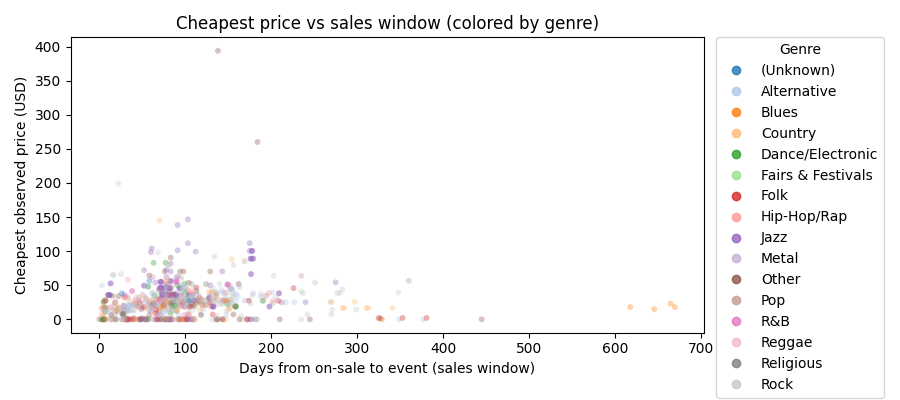

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplcursors
from matplotlib.colors import ListedColormap

# 1) Build the frame used for plotting
feat3 = (
    feat.assign(
        sales_window_days=(feat["offsale_date"] - feat["onsale_date"]).dt.days
    )
    .dropna(subset=["sales_window_days", "cheapest_price"])
    .copy()
)

# Keep only rows with a non-empty genre label
feat3["genre"] = feat3["genre"].fillna("(Unknown)")
# (Optional) trim long names for nicer tooltips
feat3["name_short"] = feat3["name"].astype(str).str.slice(0, 60)

# 2) Encode genre -> color
genres = sorted(feat3["genre"].unique())
feat3["genre_idx"] = pd.Categorical(feat3["genre"], categories=genres).codes

# tab20 has 20 distinct colors (we have 16). Use first 16 from it.
base = plt.get_cmap("tab20")
cmap = ListedColormap([base(i) for i in range(16)])

# 3) Plot
fig, ax = plt.subplots(figsize=(9, 4))

pts = ax.scatter(
    feat3["sales_window_days"],
    feat3["cheapest_price"],
    c=feat3["genre_idx"],
    cmap=cmap,
    s=18,
    alpha=0.35,
    linewidths=0,
)

ax.set_title("Cheapest price vs sales window (colored by genre)")
ax.set_xlabel("Days from on-sale to event (sales window)")
ax.set_ylabel("Cheapest observed price (USD)")

# 4) Legend for genres
# Build one proxy artist per genre (keeps legend tidy and fast)
handles = []
for g_idx, g_name in enumerate(genres[:16]):  # safety slice if >16 appear
    handles.append(
        plt.Line2D(
            [], [], linestyle="", marker="o",
            markersize=6, color=cmap(g_idx), label=g_name, alpha=0.8
        )
    )
leg = ax.legend(
    handles=handles,
    title="Genre",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.,
    ncol=1,
)
fig.tight_layout()

# 5) Hover tooltip (shows event, genre, price, dates)
cursor = mplcursors.cursor(pts, hover=True)

@cursor.connect("add")
def on_add(sel):
    i = sel.index
    row = feat3.iloc[i]
    name = row["name_short"]
    genre = row["genre"]
    price = float(row["cheapest_price"])
    win = int(row["sales_window_days"])
    when = row["datetime"]
    onsale = row["onsale_date"]
    # format dates if they are timestamps
    when_txt = when.date() if hasattr(when, "date") else str(when)
    onsale_txt = onsale.date() if hasattr(onsale, "date") else str(onsale)

    sel.annotation.set(
        text=(
            f"{name}\n"
            f"Genre: {genre}\n"
            f"Cheapest: ${price:,.2f}\n"
            f"Sales window: {win} days\n"
            f"On-sale: {onsale_txt} | Event: {when_txt}"
        ),
        fontsize=9,
        alpha=0.95,
    )

plt.show()
